### Train best configuration and model with all data available

In [50]:
### Entrenar con todo
import pandas as pd
import numpy as np#metricas de evaluacion
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def calculate_metrics(y_true,y_pred):
    f1 = f1_score(y_true,y_pred,average="weighted")
    p = precision_score(y_true,y_pred,average=None,labels=[0,1]) #1 confirmado y 0 false positivo
    r = recall_score(y_true,y_pred,average=None,labels=[0,1])
    return f1,p,r


df_sets = pd.read_csv("../Datos/koi_sets_unb.csv") 
df_labels = pd.read_csv("../Datos/koi_metadata_p_error.csv")

mask_t = (df_sets["Set"] == "Train").values
mask_v = (df_sets["Set"] == "Test").values

df_labels_t = df_labels[mask_t]
df_labels_v = df_labels[mask_v]


#lc_total = np.load("../../Processed_Data/koi_light_curves_full.npy")
#lc_total = np.load("../../Processed_Data/koi_light_curves_model_full.npy")

metadata_t= pd.read_csv("../Datos/OwnFats_unb/koi_light_curves_FATS2_metadata_train_p_error.csv")
metadata_v= pd.read_csv("../Datos/OwnFats_unb/koi_light_curves_FATS2_metadata_test_p_error.csv")
#metadata_test= pd.read_csv("../Datos/OwnFats_unb/koi_light_curves_FATS2_metadata_unb_p_error.csv")

metadata_train=pd.concat([metadata_t,metadata_v],axis=0)
y_train = pd.concat([df_labels_t,df_labels_v],axis=0)["NExScI Disposition"]

mask_train = (df_sets["Set"] != "Unlabeled").values
mask_test = (df_sets["Set"] == "Unlabeled").values

df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
#lc_train = lc_total[mask_train] 
#lc_test = lc_total[mask_test]


In [51]:
metadata_train.head()

,Minimum,Maximum,Mean,Std,IQR,Skew,Kurtosis,Q1,Q2,Slope,...,Metallicity err2,Stellar Radius err1,Stellar Radius err2,Stellar Mass err2,Stellar Mass err1,Insolation Flux err1,Insolation Flux err2,Fitted Stellar Density err1,Fitted Stellar Density err2,KOI Name
0,-4.631680,12.196450,0.016848,0.904121,0.889055,0.421609,3.092182,-0.446140,0.00000,1.516523e-07,...,-0.30,0.079,-0.079,-0.055,0.095,48.69,-36.91,0.10080,-0.39457,NaN
1,-139.122543,21.878651,-0.008001,1.205636,1.152970,-25.297327,2675.966682,-0.588930,0.00000,-2.154371e-07,...,-0.15,0.207,-0.230,-0.036,0.073,0.92,-0.76,16.58298,-31.53180,K01009.01
2,-257.681854,130.887421,-0.664128,15.756222,3.025215,-7.108926,62.182273,-0.792670,0.06117,1.067720e-06,...,-0.30,0.122,-0.041,-0.074,0.049,52.46,-21.18,0.00021,-0.00735,K07621.01
3,-20.999689,164.127502,0.006406,1.240825,1.184275,38.589603,4710.380347,-0.594215,0.00000,-3.555471e-07,...,-0.30,0.253,-2.276,-0.411,0.110,35721.31,-106451.43,0.00658,-0.00461,K06252.01
4,-130.612076,19.010851,-0.065157,3.258828,1.151395,-27.795898,899.088606,-0.579410,0.00000,8.955822e-08,...,-0.15,0.209,-0.122,-0.075,0.075,2.07,-1.12,0.76473,-0.48796,NaN


Text(0,0.5,'Count')

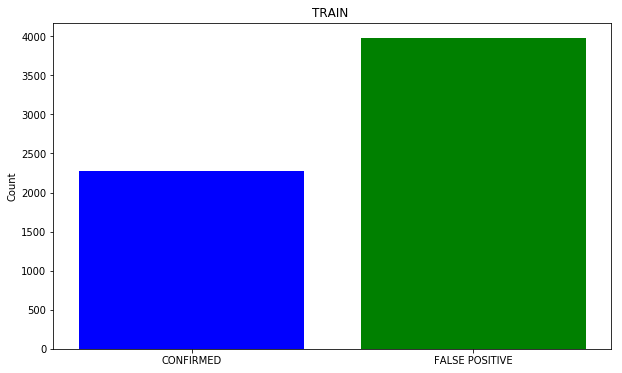

In [52]:
plt.figure(figsize=(10,6))
plt.title("TRAIN ")
plt.bar(0, np.sum(y_train=="CONFIRMED"),color="blue")
plt.bar(1, np.sum(y_train=="FALSE POSITIVE"),color="green")
plt.xticks([0,1],["CONFIRMED","FALSE POSITIVE"])
plt.ylabel("Count")

In [53]:
from collections import Counter 

Counter(mask_t)

Counter({False: 3362, True: 4692})

In [54]:
y_train_f = ((y_train=="CONFIRMED")*1).values

In [55]:
y_train_f[:20]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0])

In [56]:
y_train[:20]

1     FALSE POSITIVE
2     FALSE POSITIVE
3     FALSE POSITIVE
6     FALSE POSITIVE
9     FALSE POSITIVE
10         CONFIRMED
12    FALSE POSITIVE
13    FALSE POSITIVE
14    FALSE POSITIVE
15    FALSE POSITIVE
17    FALSE POSITIVE
21         CONFIRMED
22         CONFIRMED
23    FALSE POSITIVE
26    FALSE POSITIVE
28    FALSE POSITIVE
29         CONFIRMED
31         CONFIRMED
32    FALSE POSITIVE
36    FALSE POSITIVE
Name: NExScI Disposition, dtype: object

In [57]:
##Extraer caract con el modelo elegido
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, accuracy_score, precision_score

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score_we':make_scorer(f1_score,average='weighted'),
    'f1_score_macro':make_scorer(f1_score,average='macro'),
    'f1_score_micro':make_scorer(f1_score,average='micro')
}

#para guardar scores y graficar
f1_score_test = []
p_test = []
r_test = []

In [58]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

metadata_train.fillna(metadata_train.median(), inplace=True)
#metadata_test.fillna(metadata_test.median(), inplace=True)
X_train=metadata_train.values[:,:-1]
#X_test=metadata_test.values()

Xstd_train = std.fit_transform(X_train.astype('float'))
#Xstd_test = std.transform(X_test)

In [59]:
###MODEL 

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1, random_state=0)

param_grid = {
    'n_estimators' : [10,20,30,40,50,60,70,80,90,100],
    'min_samples_split': [5,10,15,20,25],
    #'max_depth': np.arange(5,25),
    'class_weight' : ['balanced','balanced_subsample',None]
}

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='f1_score_we',
                       cv=skf, return_train_score=False, n_jobs=-1)
grid_search.fit(Xstd_train, y_train_f)

print('Best params for completeness:', grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
bestResults = results[results.params == grid_search.best_params_]
completeness = float(bestResults['mean_test_recall_score'])
print('Completion: {:.4f}'.format(completeness))
preci = float(bestResults['mean_test_precision_score'])
print('Contamination: {:.4f}'.format(preci))
f1_w = float(bestResults['mean_test_f1_score_we'])
print('F1-score weighted: {:.4f}'.format(f1_w))
f1_ma = float(bestResults['mean_test_f1_score_macro'])
print('F1-score macro: {:.4f}'.format(f1_ma))
f1_mi = float(bestResults['mean_test_f1_score_micro'])
print('F1-score micro: {:.4f}'.format(f1_mi))

('Best params for completeness:', {'min_samples_split': 10, 'n_estimators': 70, 'class_weight': None})
Completion: 0.9035
Contamination: 0.9325
F1-score weighted: 0.9407
F1-score macro: 0.9357
F1-score micro: 0.9409


In [60]:
grid_search.best_params_

{'class_weight': None, 'min_samples_split': 10, 'n_estimators': 70}

In [76]:
#modelo final 
feat_imp = []
pred_prom = []
for i in range(10):   #con 10 o 5
    model = RandomForestClassifier(n_jobs=-1,**grid_search.best_params_)
    #model.set_params(class_weight='balanced')
    model.fit(Xstd_train,y_train_f) 
 
    pred=model.predict(Xstd_train)    ##### CAMBIAR A TEST
    pred_prom.append(pred)
    feat_imp.append(model.feature_importances_)

feat_imp = np.mean(feat_imp,axis=0)
pred_prom = np.mean(pred_prom,axis=0)>0.5

In [77]:
print("Cantidad de Confirmados %d",np.sum(pred_prom))

('Cantidad de Confirmados %d', 2277)


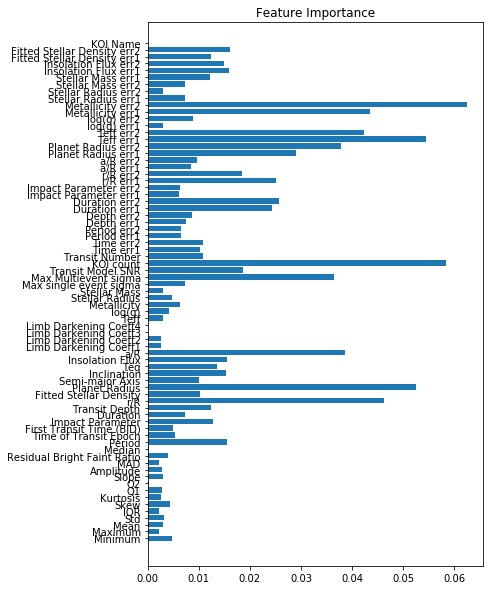

In [79]:
plt.figure(figsize=(6,10))
columns_names=list(metadata_train.columns)
plt.barh(range(len(columns_names)-1), feat_imp)
plt.yticks(range(len(columns_names)),columns_names)#, rotation= 30)
plt.title('Feature Importance')
plt.show()

In [83]:
df_results = pd.DataFrame()
df_results["KOI Name"] = df_labels_train["KOI Name"]   ###esto va con TEST
final=[]
for pred in pred_prom:
    if pred==False:
        final.append("FALSE POSITIVE")
    else: 
        final.append("CONFIRMED")
df_results["Our Disposition"] = final####model.predict(X)
df_results.head()

,KOI Name,Our Disposition
0,K00889.01,FALSE POSITIVE
1,K01009.01,FALSE POSITIVE
2,K07621.01,FALSE POSITIVE
3,K06252.01,FALSE POSITIVE
6,K04162.01,FALSE POSITIVE


In [85]:
Counter(final)

Counter({'CONFIRMED': 2277, 'FALSE POSITIVE': 3980})

In [86]:
final[:20]

['FALSE POSITIVE',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'CONFIRMED',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'CONFIRMED',
 'CONFIRMED',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'FALSE POSITIVE',
 'CONFIRMED',
 'CONFIRMED',
 'FALSE POSITIVE',
 'FALSE POSITIVE']

In [ ]:
#save!
df_results.to_csv("koi_disposition_2019.csv",index=False)

In [94]:
def mask_final(preds):
    mask_conf=[]
    mask_fp=[]
    ###
    for pred in preds:
        if pred=="CONFIRMED":
            mask_conf.append(True)
        else:
            mask_conf.append(False)
    mask_fp=~np.array(mask_conf)
    return mask_conf,mask_fp


In [95]:
mask_con,mask_fp=mask_final(final)

In [109]:
mask_fp[:10]

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True])

In [99]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.preprocessing import StandardScaler

data_num=X=metadata_train.values[:,:-1]   ###DEBERIA SER LA DE TEST
escalado = StandardScaler().fit_transform(data_num)


/users/mbugueno/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/users/mbugueno/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [121]:
from sklearn.decomposition import PCA,KernelPCA

escalado_kpca = KernelPCA(kernel="rbf",n_components=2,fit_inverse_transform=True, gamma=0.15).fit_transform(escalado)

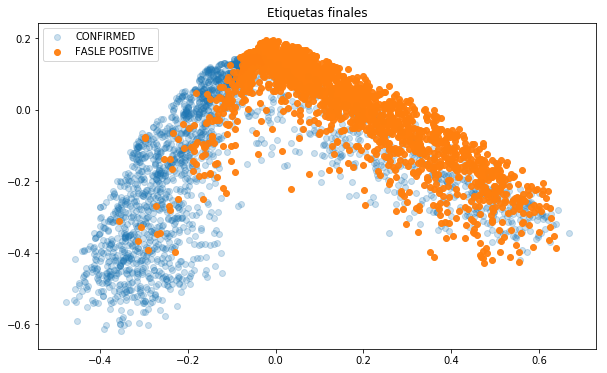

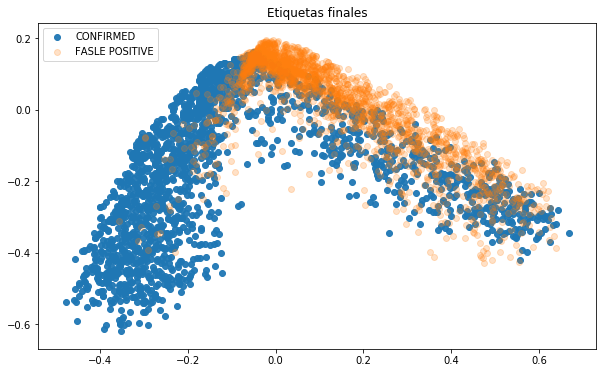

In [130]:
plt.figure(figsize=(10,6))
plt.scatter(escalado_kpca[mask_con][:,0], escalado_kpca[mask_con][:,1],label="CONFIRMED",alpha=0.23)
plt.scatter(escalado_kpca[mask_fp][:,0], escalado_kpca[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.95)

#plt.scatter(escalado2[:,0], escalado2[:,1],label="FALSE POSITIVE")
plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(escalado_kpca[mask_con][:,0], escalado_kpca[mask_con][:,1],label="CONFIRMED",alpha=0.95)
plt.scatter(escalado_kpca[mask_fp][:,0], escalado_kpca[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.23)

#plt.scatter(escalado2[:,0], escalado2[:,1],label="FALSE POSITIVE")
plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

In [131]:
from sklearn.decomposition import PCA,KernelPCA

escalado_kpca = KernelPCA(kernel="rbf",n_components=2,fit_inverse_transform=True, gamma=0.05).fit_transform(escalado)

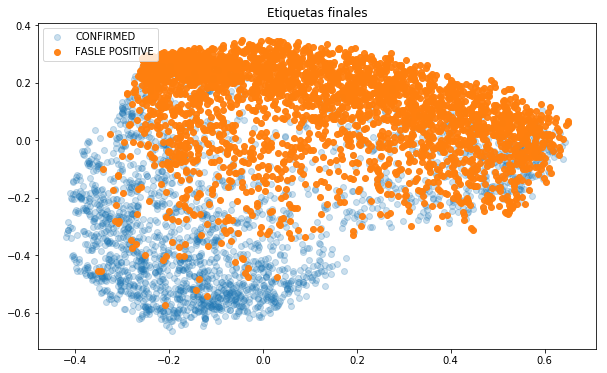

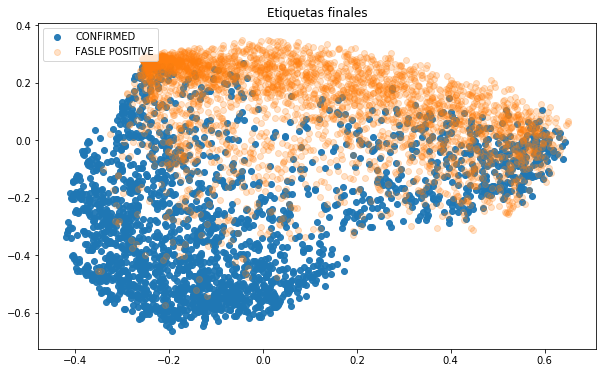

In [132]:
plt.figure(figsize=(10,6))
plt.scatter(escalado_kpca[mask_con][:,0], escalado_kpca[mask_con][:,1],label="CONFIRMED",alpha=0.23)
plt.scatter(escalado_kpca[mask_fp][:,0], escalado_kpca[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.95)

#plt.scatter(escalado2[:,0], escalado2[:,1],label="FALSE POSITIVE")
plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(escalado_kpca[mask_con][:,0], escalado_kpca[mask_con][:,1],label="CONFIRMED",alpha=0.95)
plt.scatter(escalado_kpca[mask_fp][:,0], escalado_kpca[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.23)

#plt.scatter(escalado2[:,0], escalado2[:,1],label="FALSE POSITIVE")
plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

In [133]:
from sklearn.decomposition import PCA,KernelPCA

escalado_kpca = KernelPCA(kernel="rbf",n_components=2,fit_inverse_transform=True).fit_transform(escalado)

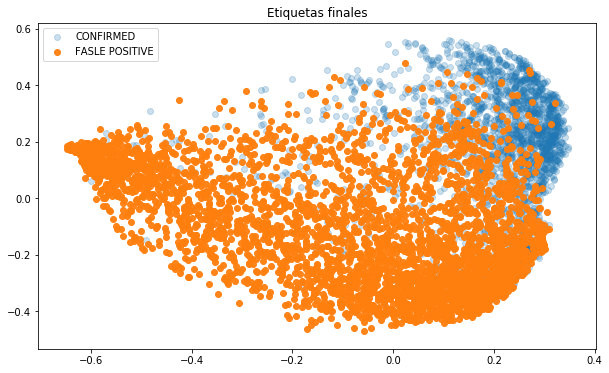

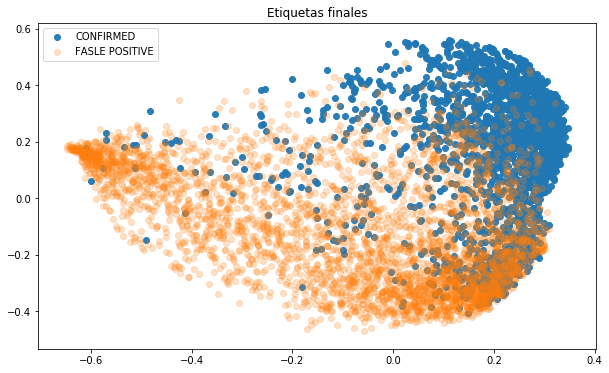

In [134]:
plt.figure(figsize=(10,6))
plt.scatter(escalado_kpca[mask_con][:,0], escalado_kpca[mask_con][:,1],label="CONFIRMED",alpha=0.23)
plt.scatter(escalado_kpca[mask_fp][:,0], escalado_kpca[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.95)

#plt.scatter(escalado2[:,0], escalado2[:,1],label="FALSE POSITIVE")
plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(escalado_kpca[mask_con][:,0], escalado_kpca[mask_con][:,1],label="CONFIRMED",alpha=0.95)
plt.scatter(escalado_kpca[mask_fp][:,0], escalado_kpca[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.23)

#plt.scatter(escalado2[:,0], escalado2[:,1],label="FALSE POSITIVE")
plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()